<a href="https://colab.research.google.com/github/simeonnalovski/NLP-Sentiment-Analysis-and-Text-Generation-in-Finance-/blob/main/Real_Fine_Tune_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install newsapi-python datasets

Epoch 1/2 - Training Loss: 0.6354
Epoch 2/2 - Training Loss: 0.3144
Evaluation Accuracy: 0.8255
Evaluation Precision: 0.8110
Evaluation Recall: 0.8255
Evaluation F1 Score: 0.8125


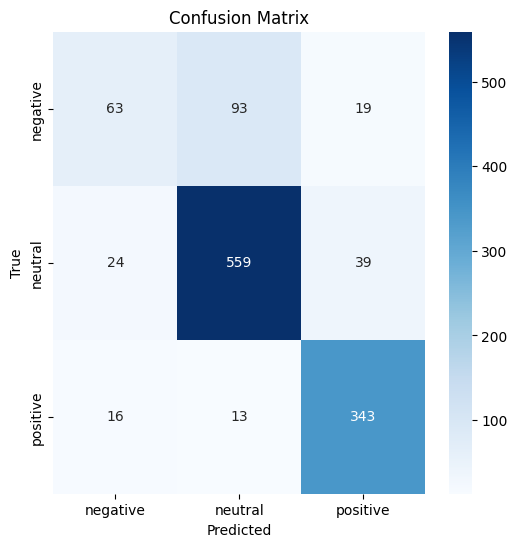

Finetuned FinBERT model saved to /content/drive/MyDrive/models/finetuned_finbert


In [ ]:
# --- CELL 1: Fine-tuning FinBERT with CSV Data ---
import os
import torch
import pandas as pd
from datetime import datetime, timedelta, timezone
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
DATA_CSV_PATH = '/content/drive/MyDrive/data/data.csv' # Path to your training data CSV
MODEL_SAVE_PATH = '/content/drive/MyDrive/models/finetuned_finbert'

# Load Pre-trained Model and Tokenizer
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3).to(device) # Ensure num_labels matches your sentiment classes

# Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label)
        }

# Load and Prepare Data
try:
    df = pd.read_csv(DATA_CSV_PATH)
    if 'Sentence' not in df.columns or 'Sentiment' not in df.columns:
        raise ValueError("CSV file must contain 'Sentence' and 'Sentiment' columns.")
    texts = df['Sentence'].tolist()
    sentiments = df['Sentiment'].tolist()

    # Convert sentiment labels to numerical values
    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    labels = [sentiment_map[s.lower()] for s in sentiments if s.lower() in sentiment_map]
    filtered_texts = [texts[i] for i, s in enumerate(sentiments) if s.lower() in sentiment_map]

    #podelba na mnozestvo za testiranje i treniranje
    train_texts, test_texts, train_labels, test_labels = train_test_split(filtered_texts, labels, test_size=0.2, random_state=42)

    # soodvetni dataset i dataloader objekti
    train_dataset = SentimentDataset(train_texts, train_labels, finbert_tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataset = SentimentDataset(test_texts, test_labels, finbert_tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=16)

except FileNotFoundError:
    print(f"Error: CSV file not found at {DATA_CSV_PATH}")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()

# Fine-tuning Function
def finetune(model, dataloader, optimizer, loss_fn, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_loss:.4f}")

# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().tolist()
            true_labels.extend(labels.cpu().tolist())
            predicted_labels.extend(predictions)
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f"Evaluation Accuracy: {accuracy:.4f}")
    print(f"Evaluation Precision: {precision:.4f}")
    print(f"Evaluation Recall: {recall:.4f}")
    print(f"Evaluation F1 Score: {f1:.4f}")

    labels_order = list(sentiment_map.keys())
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(sentiment_map.values()))
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Initialize Optimizer
optimizer = AdamW(finbert_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# fino-podesuvanje
finetune(finbert_model, train_dataloader, optimizer, loss_fn, epochs=2)

#evaluacija na model
evaluate(finbert_model, test_dataloader)

# Save the fine-tuned model
finbert_model.save_pretrained(MODEL_SAVE_PATH)
finbert_tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"Finetuned FinBERT model saved to {MODEL_SAVE_PATH}")

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



 Stock: META
Mean sentiment score (Fine-tuned FinBERT): 1.1717
Total sentiment score: 116
Sentiment category: neutral
Data saved to: /content/drive/MyDrive/data/stock_sentiment.csv

 Evaluating  Fine-tuned FinBERT against RoBert-A-labeled news
 Accuracy:   0.7273
 Precision:  0.7321
 Recall:     0.7273
 F1 Score:   0.7258


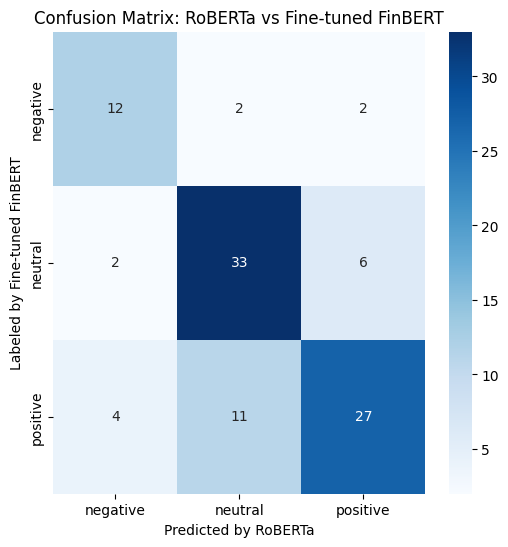

In [ ]:
# --- CELL 2: Predict Sentiment of Fetched News and Evaluate Against RoBERTa ---
import os
import torch
import pandas as pd
from datetime import datetime, timedelta, timezone
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from newsapi import NewsApiClient
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
OUTPUT_PATH = '/content/drive/MyDrive/data/stock_sentiment.csv'
NEWS_API_KEY = "YOUR_NEWS_API_KEY"
FINETUNED_MODEL_PATH = '/content/drive/MyDrive/models/finetuned_finbert'

# Load Fine-tuned Model and Tokenizer
finbert_tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_PATH)
finbert_model = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL_PATH).to(device)
finbert_model.eval() # Set model to evaluation mode

# Load RoBERTa Pipeline
roberta_pipe = pipeline("text-classification", model="soleimanian/financial-roberta-large-sentiment")

# News API
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

# Fetch news
def fetch_recent_news(stock_symbol):
    end_date = datetime.now(timezone.utc)
    start_date = max(end_date - timedelta(days=28))
    articles = newsapi.get_everything(
        q=stock_symbol,
        from_param=start_date.strftime('%Y-%m-%d'),
        to=end_date.strftime('%Y-%m-%d'),
        language='en',
        sort_by='relevancy',
        page_size=100,
        page=1
    )
    return [article["title"] for article in articles.get("articles", []) if article["title"]]

# Classify with fine-tuned FinBERT
def classify_with_finetuned_finbert(texts, tokenizer, model, device, batch_size=16):
    results = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    for i in range(0, len(texts), batch_size):
        batch = texts[i: i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).tolist()
        results.extend(predictions)
    return [label_map[p] for p in results]

# Classify with RoBERTa
def classify_with_roberta(texts):
    preds = roberta_pipe(texts, truncation=True, padding=True)
    return [p["label"].lower() for p in preds]

# Sentiment Category
def get_sentiment_category(mean_score):
    normalized_score = mean_score / 2
    if normalized_score < 0.3:
        return "negative"
    elif normalized_score < 0.7:
        return "neutral"
    else:
        return "positive"

# Evaluation
def evaluate_models(df):
    true_labels = df["roberta_label"].tolist()
    predicted_labels = df["finbert_label"].tolist()

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="weighted")

    print("\n Evaluating  Fine-tuned FinBERT against RoBert-A-labeled news")
    print(f" Accuracy:   {accuracy:.4f}")
    print(f" Precision:  {precision:.4f}")
    print(f" Recall:     {recall:.4f}")
    print(f" F1 Score:   {f1:.4f}")

    labels_order = ["negative", "neutral", "positive"]
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted by RoBERTa")
    plt.ylabel("Labeled by Fine-tuned FinBERT")
    plt.title("Confusion Matrix: RoBERTa vs Fine-tuned FinBERT")
    plt.show()

# --- MAIN EXECUTION ---

# prezemanje na vesti
STOCK_SYMBOL = "META"
titles = fetch_recent_news(STOCK_SYMBOL)
if not titles:
    raise ValueError(f"No recent news found for {STOCK_SYMBOL}")

finbert_labels = classify_with_finetuned_finbert(titles, finbert_tokenizer, finbert_model, device)
roberta_labels = classify_with_roberta(titles)

#podatocna ramka za evaluacija
df = pd.DataFrame({
    "headline": titles,
    "stock": STOCK_SYMBOL,
    "finbert_label": finbert_labels,
    "roberta_label": roberta_labels
})

# ocenuvanje
sentiment_score_map = {"negative": 0, "neutral": 1, "positive": 2}
df["score"] = df["finbert_label"].map(sentiment_score_map)
mean_sentiment = df["score"].mean()
total_sentiment = df["score"].sum()
sentiment_category = get_sentiment_category(mean_sentiment)

# zacuvuvnje na rezultati
new_entry = pd.DataFrame([{ "stock": STOCK_SYMBOL, "mean_sentiment": mean_sentiment, "total_sentiment": total_sentiment,
                           "sentiment": sentiment_category }])
if os.path.exists(OUTPUT_PATH):
    existing_df = pd.read_csv(OUTPUT_PATH)
    existing_df = existing_df[existing_df["stock"] != STOCK_SYMBOL]
else:
    existing_df = pd.DataFrame(columns=["stock", "mean_sentiment", "total_sentiment", "sentiment"])

updated_df = pd.concat([existing_df, new_entry], ignore_index=True)
updated_df.to_csv(OUTPUT_PATH, index=False)

# izlez
print(f"\n Stock: {STOCK_SYMBOL}")
print(f"Mean sentiment score (Fine-tuned FinBERT): {mean_sentiment:.4f}")
print(f"Total sentiment score: {total_sentiment}")
print(f"Sentiment category: {sentiment_category}")
print(f"Data saved to: {OUTPUT_PATH}")

# evaluacija
evaluate_models(df)

In [ ]:
df

,headline,stock,finbert_label,roberta_label,score
0,Meta’s smart glasses can now describe what you...,META,neutral,positive,1
1,Did WhatsApp really need Meta?,META,neutral,neutral,1
2,Meta awarded $167.25 million over Pegasus spyw...,META,positive,positive,2
3,Meta asks judge to throw out antitrust case mi...,META,negative,positive,0
4,Google Taps Xreal for ‘Optical See-Through’ Sm...,META,positive,positive,2
...,...,...,...,...,...
94,"Apple's AI Smart Glasses to Arrive in 2026, Ac...",META,positive,neutral,2
95,Inside an Instagram meme empire's strategy to ...,META,neutral,neutral,1
96,AI companies were handed a major victory in Tr...,META,positive,positive,2
97,Mark Zuckerberg says his management style invo...,META,neutral,neutral,1


In [ ]:
titles

['Meta’s smart glasses can now describe what you’re seeing in more detail',
 'Did WhatsApp really need Meta?',
 'Meta awarded $167.25 million over Pegasus spyware attack',
 'Meta asks judge to throw out antitrust case mid-trial',
 'Google Taps Xreal for ‘Optical See-Through’ Smart Glasses That Could Beat Meta’s Orion AR Glasses',
 'Meta’s antitrust defense wraps with one big claim: WhatsApp and Instagram couldn’t be better',
 'DOGE Used Meta AI Model to Review Emails From Federal Workers',
 'Meta faces Democratic probe into plans to power a giant data center with gas',
 'Meta’s AI app is a nightmarish social feed',
 'How Apple lost control of the App Store',
 'Instagram CEO testifies about competing with TikTok: ‘You’re either growing, or you’re slowly dying’',
 'Meta’s beef with the press flares at its antitrust trial',
 'Threads follows Instagram with more links in bio',
 'Sam Altman and Elon Musk are racing to build an ‘everything app’',
 'Apple’s Eddy Cue: ‘You may not need an iPho